In [1]:
import numpy as np

edges = np.loadtxt('filename.txt', dtype=int)
num_nodes = np.max(edges) + 1

adj_matrix = np.zeros((num_nodes, num_nodes))
for edge in edges:
    adj_matrix[edge[0], edge[1]] = 1
    adj_matrix[edge[1], edge[0]] = 1

print(adj_matrix.shape)


(1005, 1005)


In [2]:
edges.shape

(25571, 2)

In [3]:
row, col = np.where(adj_matrix == 1)

edge = np.stack((row, col), axis=0)
print(edge.shape)

(2, 32770)


In [4]:
import torch
edge = torch.tensor(edge, dtype=torch.long)

In [5]:
import torch
x = torch.tensor(adj_matrix, dtype=torch.float)


In [6]:
c = np.loadtxt('f2.txt', dtype=int)
num_nodes = np.max(c) + 1

communities = np.zeros((num_nodes))
for e in range(len(c)):
    communities[e] = c[e][1]
y = torch.tensor(communities, dtype=torch.long)

nodes_y=[]
labels_y=[]
for i, lbl in enumerate(y):
  nodes_y.append(i)
  labels_y.append(lbl)


In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = GCNConv(x.shape[1], 64)
        self.bn1 = BatchNorm(64)
        self.conv2 = GCNConv(64, 128)
        self.bn2 = BatchNorm(128)
        self.conv3 = GCNConv(128, 16)
        self.conv4 = GCNConv(16, 128)
        self.bn3 = BatchNorm(128)
        self.conv5 = GCNConv(128, 64)
        self.bn4 = BatchNorm(64)
        self.conv6 = GCNConv(64, x.shape[1])

    def encode(self, x, edge):
        x = self.conv1(x, edge)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(input=x, training=self.training)
        x = self.conv2(x, edge)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(input=x, training=self.training)
        x = self.conv3(x, edge)
        return x

    def decode(self, x, edge):
        x = self.conv4(x, edge)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv5(x, edge)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv6(x, edge)
        return x

    def forward(self, x, edge):
        z = self.encode(x, edge)
        x = self.decode(z, edge)
        return x


In [ ]:
pip install torch_geometric

In [9]:
edge.shape

torch.Size([2, 32770])

In [10]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_max_pool, BatchNorm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

model = AutoEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    x_hat = model(x, edge)
    loss = criterion(x_hat, x)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        val_loss = criterion(model(x, edge), x)
        print(f"Epoch: {epoch+1}, Train Loss: {loss.item()}")

Epoch: 1, Train Loss: 225.5305633544922
Epoch: 11, Train Loss: 192.08395385742188
Epoch: 21, Train Loss: 185.94883728027344
Epoch: 31, Train Loss: 182.59461975097656
Epoch: 41, Train Loss: 180.3404541015625
Epoch: 51, Train Loss: 178.4768524169922
Epoch: 61, Train Loss: 176.80711364746094
Epoch: 71, Train Loss: 175.28994750976562
Epoch: 81, Train Loss: 173.85391235351562
Epoch: 91, Train Loss: 172.76011657714844
Epoch: 101, Train Loss: 171.87380981445312
Epoch: 111, Train Loss: 171.18894958496094
Epoch: 121, Train Loss: 170.80227661132812
Epoch: 131, Train Loss: 170.11805725097656
Epoch: 141, Train Loss: 170.05540466308594
Epoch: 151, Train Loss: 169.063720703125
Epoch: 161, Train Loss: 168.92323303222656
Epoch: 171, Train Loss: 168.3912811279297
Epoch: 181, Train Loss: 168.44888305664062
Epoch: 191, Train Loss: 168.2241668701172


In [11]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

source = ColumnDataSource(data=dict(x=list(range(len(losses))), y=losses))
plot = figure(title='Training Loss', x_axis_label='Epoch', y_axis_label='Loss')
line = plot.line('x', 'y', source=source)
line.glyph.line_alpha = 0.8
line.glyph.line_color = "blue"
output_notebook()
show(plot)

In [12]:
probs = F.softmax(model.encode(x, edge), dim=1)
_, communities = torch.max(probs, dim=1)
communities

nodes=[]
labels=[]
for i, lbl in enumerate(communities):
  nodes.append(i)
  labels.append(lbl)

# nodes[:10], labels[:100]
print(max(labels))

tensor(15)


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
def get_n_m(x):
    n = int(x ** 0.5)
    while x % n != 0:
        n -= 1
    return tuple(sorted((n, x // n)))

def visualize(edges, nodes, labels, communities, x):
    np.random.seed = 30
    cmap = plt.cm.get_cmap('hsv', 42)
    node_labels = np.array(labels)
    norm = plt.Normalize(vmin=node_labels.min(), vmax=node_labels.max())
    color_map = cmap(norm(node_labels))

    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = {}
    n = np.ceil(x ** 0.5)
    print(n)

    for node, community in enumerate(communities):
        x = (community % n) * 10  + np.random.random() * 7
        y = (community // n) * 10 + np.random.random() * 7
        pos[node] = [x, y]

    nx.draw(G, pos=pos, with_labels=False, node_size=3, width=0.01, node_color=color_map)

In [14]:
lst = []
for el in labels:
  lst.append(int(el))
print(set(lst))

{0, 1, 3, 5, 9, 11, 13, 14, 15}


<ipython-input-13-2b1cd59c9b41>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 42)


7.0


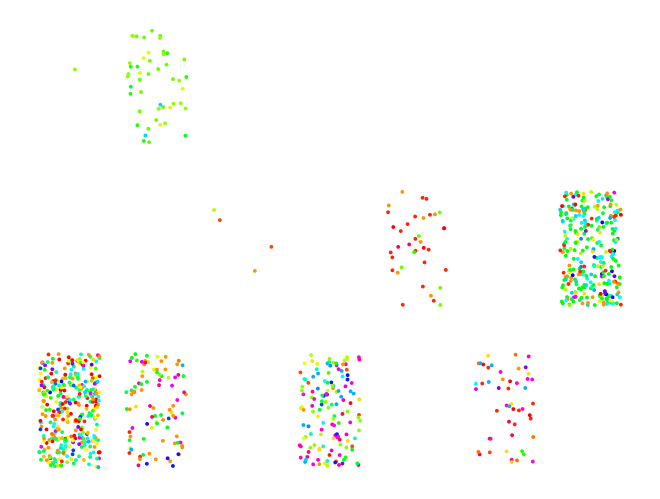

In [15]:
visualize([ ], nodes, labels_y, labels, 42)

<ipython-input-13-2b1cd59c9b41>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 42)


7.0


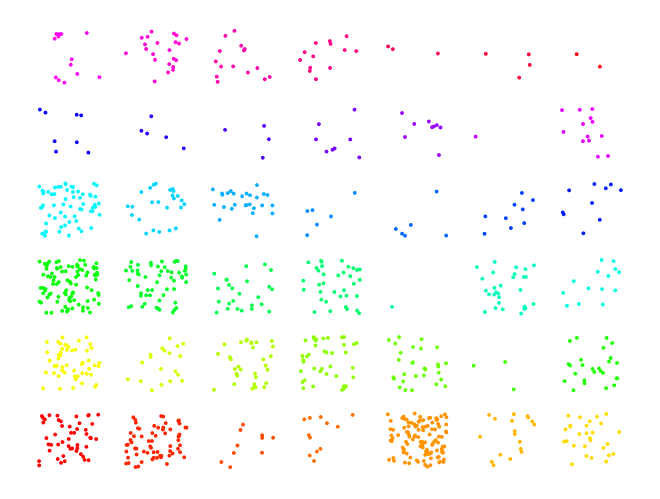

In [16]:
visualize([ ], nodes_y, labels_y, labels_y, 42)

In [17]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi_score_gnn = normalized_mutual_info_score(labels_y, labels)
nmi_score_gnn

0.27817622123525854

In [ ]:
pip install python-louvain

In [20]:
import community as community_lv
G = nx.Graph()
G.add_nodes_from(nodes_y)
G.add_edges_from(edges)
modularity_score = community_lv.modularity({i: labels[i] for i in range(len(labels))}, G)
print("Modularity score: ", modularity_score)